In [1]:
import tensorflow as tf
import os 
import numpy as np
from tensorflow import keras
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from rbm import RBM, sample
from scipy.stats import bernoulli
from scipy import stats
import pandas as pd

In [2]:
'financial function'
def get_return(Y):
    R = Y.pct_change()[1:]
    return(R)

def get_norm(data):
    mu=data.mean(axis=0)
    sig=data.std(axis=0)
    return((data-mu)/sig)

def cumreturn(ret):
    return((1+ret).cumprod())

def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)] 

# Train on real, test on real
## SPX dataset

In [3]:
df=pd.read_excel('VIX.xlsx',index_col='Date')
dft=df.T
D_vix=df['VIX']
D_sp=df['SPX 500']

R_sp=get_return(D_sp)


ret=get_return(D_sp)
ret=np.array(ret)
mu_r=ret.mean()
s_r=ret.std()


## Defining a label 

### based on rolling mean value

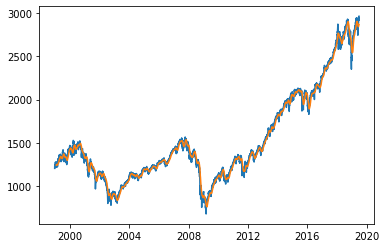

In [21]:
data=D_sp
roll_data=data.rolling(30).mean()
roll_data=roll_data.dropna()
plt.plot(D_sp)
plt.plot(roll_data)

### categorical label: 3 classes

In [22]:
def get_label(p_ini,data):
    label=0
    for k in range(len(data)):
        r=(float(data.iloc[k])-p_ini)/p_ini
        if r>0.025:
            label=0
            break
        elif r<-0.025:
            label=1
            break
        else:
            label=2
    return(label)

D=D_sp[:30]
p_ini=D.iloc[0]
data=D[1:]
get_label(p_ini,data) 


0

## preprocessing: 
### return datasets + associated labels

In [24]:

window=30
day_forcast=20
roll_window=30

def labelized(data_set):
    D=[]
    L=[]
    for k in range(0,len(data_set),roll_window):
        if k+window+day_forcast<len(data_set):
            df=data_set[k:k+window]
            p_ini=df.iloc[-1]
            data=data_set[k+window:k+window+day_forcast]
            label=get_label(p_ini,data)
            D.append(np.array(df))
            L.append(label)
        else:
            break

    D=pd.concat([pd.DataFrame(D[i]) for i in range(len(L))],axis=1)
    L=np.array(L)
    return(D,L)

def labelized_roll(data_set):
    roll_data=data_set.rolling(window).mean()
    data_set_new=data_set[window-1:]
    D=[]
    L=[]
    for k in range(0,len(data_set_new),roll_window):
        if k+window+day_forcast<len(data_set):
            df=data_set[k:k+window]
            roll_data_df=roll_data[k:k+window]
            p_ini=roll_data_df.iloc[-1]
            data=data_set_new[k+window:k+window+day_forcast]
            label=get_label(p_ini,data)
            D.append(np.array(df))
            L.append(label)
        else:
            break

    D=pd.concat([pd.DataFrame(D[i]) for i in range(len(L))],axis=1)
    L=np.array(L)
    return(D,L)

D,L=labelized(D_sp)
D,L=labelized_roll(D_sp)

In [25]:
D.shape
L.shape

(177,)

In [26]:
N_sample=D.shape[1]
front=int(0.8*N_sample)

D_n=np.array(D)
x_train=D_n[:,0:front]
x_test=D_n[:,front:D_n.shape[1]]

y_train=L[:front]
y_test=L[front:]


nb_classes =len(np.unique(y_test))



x_test.shape
x_train.shape

(30, 141)

#### one hot encoding 

In [27]:
Y_train = keras.utils.to_categorical(y_train, nb_classes) 
Y_test = keras.utils.to_categorical(y_test, nb_classes) 
Y_train.shape

(141, 3)

In [28]:
x_train=get_norm(x_train)
x_test=get_norm(x_test)
x_train.shape


(30, 141)

In [29]:
x_train=x_train.T
x_test=x_test.T
x_train.shape

(141, 30)

In [30]:
x_train.shape
x_test.shape

(36, 30)

## defining the classifier: MLP

In [31]:
batch_size=50
nb_epochs=500

x = keras.layers.Input((window,))
y= keras.layers.Dropout(0.1)(x) 
y = keras.layers.Dense(500, activation='relu')(y) 
y = keras.layers.Dropout(0.2)(y) 
y = keras.layers.Dense(500, activation='relu')(y) 
y = keras.layers.Dropout(0.2)(y) 
y = keras.layers.Dense(500, activation = 'relu')(y) 
y = keras.layers.Dropout(0.3)(y) 
out = keras.layers.Dense(nb_classes, activation='softmax')(y) 

model = keras.models.Model(inputs=x, outputs=out)
optimizer = keras.optimizers.Adadelta() 
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) 

hist = model.fit(x_train, Y_train, batch_size=batch_size, nb_epoch=nb_epochs, 
verbose=2, validation_data=(x_test, Y_test))


W0919 14:28:27.451601 13524 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 141 samples, validate on 36 samples
Epoch 1/500
141/141 - 0s - loss: 1.0511 - acc: 0.4326 - val_loss: 1.0901 - val_acc: 0.3611
Epoch 2/500
141/141 - 0s - loss: 1.0500 - acc: 0.4539 - val_loss: 1.0888 - val_acc: 0.3611
Epoch 3/500
141/141 - 0s - loss: 1.0543 - acc: 0.4255 - val_loss: 1.0875 - val_acc: 0.3611
Epoch 4/500
141/141 - 0s - loss: 1.0705 - acc: 0.3901 - val_loss: 1.0861 - val_acc: 0.3611
Epoch 5/500
141/141 - 0s - loss: 1.0626 - acc: 0.4255 - val_loss: 1.0848 - val_acc: 0.3611
Epoch 6/500
141/141 - 0s - loss: 1.0552 - acc: 0.4468 - val_loss: 1.0836 - val_acc: 0.3611
Epoch 7/500
141/141 - 0s - loss: 1.0562 - acc: 0.4255 - val_loss: 1.0822 - val_acc: 0.3889
Epoch 8/500
141/141 - 0s - loss: 1.0457 - acc: 0.4397 - val_loss: 1.0809 - val_acc: 0.3889
Epoch 9/500
141/141 - 0s - loss: 1.0487 - acc: 0.4397 - val_loss: 1.0796 - val_acc: 0.3889
Epoch 10/500
141/141 - 0s - loss: 1.0553 - acc: 0.4539 - val_loss: 1.0784 - val_acc: 0.3889
Epoch 11/500
141/141 - 0s - loss: 1.0399 - a

Epoch 90/500
141/141 - 0s - loss: 0.9494 - acc: 0.6170 - val_loss: 0.9885 - val_acc: 0.5556
Epoch 91/500
141/141 - 0s - loss: 0.9262 - acc: 0.6312 - val_loss: 0.9876 - val_acc: 0.5556
Epoch 92/500
141/141 - 0s - loss: 0.9271 - acc: 0.6596 - val_loss: 0.9866 - val_acc: 0.5556
Epoch 93/500
141/141 - 0s - loss: 0.9277 - acc: 0.6099 - val_loss: 0.9857 - val_acc: 0.5556
Epoch 94/500
141/141 - 0s - loss: 0.9618 - acc: 0.5248 - val_loss: 0.9847 - val_acc: 0.5556
Epoch 95/500
141/141 - 0s - loss: 0.9379 - acc: 0.5603 - val_loss: 0.9837 - val_acc: 0.5556
Epoch 96/500
141/141 - 0s - loss: 0.9334 - acc: 0.5816 - val_loss: 0.9828 - val_acc: 0.5556
Epoch 97/500
141/141 - 0s - loss: 0.9365 - acc: 0.6312 - val_loss: 0.9818 - val_acc: 0.5556
Epoch 98/500
141/141 - 0s - loss: 0.9391 - acc: 0.5957 - val_loss: 0.9808 - val_acc: 0.5833
Epoch 99/500
141/141 - 0s - loss: 0.9262 - acc: 0.6170 - val_loss: 0.9799 - val_acc: 0.5833
Epoch 100/500
141/141 - 0s - loss: 0.9361 - acc: 0.5957 - val_loss: 0.9790 - val

Epoch 179/500
141/141 - 0s - loss: 0.8695 - acc: 0.6525 - val_loss: 0.9153 - val_acc: 0.6111
Epoch 180/500
141/141 - 0s - loss: 0.8461 - acc: 0.6667 - val_loss: 0.9147 - val_acc: 0.6111
Epoch 181/500
141/141 - 0s - loss: 0.8501 - acc: 0.6667 - val_loss: 0.9140 - val_acc: 0.6111
Epoch 182/500
141/141 - 0s - loss: 0.8557 - acc: 0.6525 - val_loss: 0.9133 - val_acc: 0.6111
Epoch 183/500
141/141 - 0s - loss: 0.8734 - acc: 0.6312 - val_loss: 0.9126 - val_acc: 0.6111
Epoch 184/500
141/141 - 0s - loss: 0.8318 - acc: 0.7163 - val_loss: 0.9120 - val_acc: 0.6111
Epoch 185/500
141/141 - 0s - loss: 0.8661 - acc: 0.6809 - val_loss: 0.9113 - val_acc: 0.6111
Epoch 186/500
141/141 - 0s - loss: 0.8597 - acc: 0.6312 - val_loss: 0.9107 - val_acc: 0.6111
Epoch 187/500
141/141 - 0s - loss: 0.8384 - acc: 0.6667 - val_loss: 0.9100 - val_acc: 0.6111
Epoch 188/500
141/141 - 0s - loss: 0.8642 - acc: 0.6241 - val_loss: 0.9094 - val_acc: 0.6111
Epoch 189/500
141/141 - 0s - loss: 0.8501 - acc: 0.6241 - val_loss: 0.

Epoch 267/500
141/141 - 0s - loss: 0.8044 - acc: 0.6525 - val_loss: 0.8670 - val_acc: 0.6111
Epoch 268/500
141/141 - 0s - loss: 0.7837 - acc: 0.7092 - val_loss: 0.8666 - val_acc: 0.6111
Epoch 269/500
141/141 - 0s - loss: 0.8009 - acc: 0.6312 - val_loss: 0.8661 - val_acc: 0.6111
Epoch 270/500
141/141 - 0s - loss: 0.7917 - acc: 0.6738 - val_loss: 0.8657 - val_acc: 0.6111
Epoch 271/500
141/141 - 0s - loss: 0.7934 - acc: 0.6809 - val_loss: 0.8653 - val_acc: 0.6111
Epoch 272/500
141/141 - 0s - loss: 0.8029 - acc: 0.6596 - val_loss: 0.8649 - val_acc: 0.6111
Epoch 273/500
141/141 - 0s - loss: 0.7990 - acc: 0.6454 - val_loss: 0.8645 - val_acc: 0.6111
Epoch 274/500
141/141 - 0s - loss: 0.7792 - acc: 0.6383 - val_loss: 0.8640 - val_acc: 0.6111
Epoch 275/500
141/141 - 0s - loss: 0.7937 - acc: 0.6809 - val_loss: 0.8637 - val_acc: 0.6111
Epoch 276/500
141/141 - 0s - loss: 0.8072 - acc: 0.6312 - val_loss: 0.8633 - val_acc: 0.6111
Epoch 277/500
141/141 - 0s - loss: 0.7867 - acc: 0.6383 - val_loss: 0.

Epoch 355/500
141/141 - 0s - loss: 0.7537 - acc: 0.6596 - val_loss: 0.8383 - val_acc: 0.6389
Epoch 356/500
141/141 - 0s - loss: 0.7521 - acc: 0.6950 - val_loss: 0.8380 - val_acc: 0.6389
Epoch 357/500
141/141 - 0s - loss: 0.7337 - acc: 0.7163 - val_loss: 0.8378 - val_acc: 0.6389
Epoch 358/500
141/141 - 0s - loss: 0.7319 - acc: 0.7092 - val_loss: 0.8376 - val_acc: 0.6389
Epoch 359/500
141/141 - 0s - loss: 0.7572 - acc: 0.6596 - val_loss: 0.8373 - val_acc: 0.6389
Epoch 360/500
141/141 - 0s - loss: 0.7421 - acc: 0.7305 - val_loss: 0.8371 - val_acc: 0.6389
Epoch 361/500
141/141 - 0s - loss: 0.7523 - acc: 0.6738 - val_loss: 0.8368 - val_acc: 0.6389
Epoch 362/500
141/141 - 0s - loss: 0.7650 - acc: 0.6879 - val_loss: 0.8366 - val_acc: 0.6389
Epoch 363/500
141/141 - 0s - loss: 0.7388 - acc: 0.6738 - val_loss: 0.8364 - val_acc: 0.6389
Epoch 364/500
141/141 - 0s - loss: 0.7421 - acc: 0.6738 - val_loss: 0.8362 - val_acc: 0.6389
Epoch 365/500
141/141 - 0s - loss: 0.7502 - acc: 0.6738 - val_loss: 0.

Epoch 443/500
141/141 - 0s - loss: 0.7415 - acc: 0.6596 - val_loss: 0.8230 - val_acc: 0.6389
Epoch 444/500
141/141 - 0s - loss: 0.7226 - acc: 0.6525 - val_loss: 0.8229 - val_acc: 0.6389
Epoch 445/500
141/141 - 0s - loss: 0.7098 - acc: 0.6879 - val_loss: 0.8228 - val_acc: 0.6389
Epoch 446/500
141/141 - 0s - loss: 0.7186 - acc: 0.6667 - val_loss: 0.8226 - val_acc: 0.6389
Epoch 447/500
141/141 - 0s - loss: 0.7104 - acc: 0.6809 - val_loss: 0.8225 - val_acc: 0.6389
Epoch 448/500
141/141 - 0s - loss: 0.7357 - acc: 0.6525 - val_loss: 0.8224 - val_acc: 0.6389
Epoch 449/500
141/141 - 0s - loss: 0.7084 - acc: 0.6879 - val_loss: 0.8223 - val_acc: 0.6389
Epoch 450/500
141/141 - 0s - loss: 0.7198 - acc: 0.7021 - val_loss: 0.8222 - val_acc: 0.6389
Epoch 451/500
141/141 - 0s - loss: 0.7370 - acc: 0.7092 - val_loss: 0.8221 - val_acc: 0.6389
Epoch 452/500
141/141 - 0s - loss: 0.7128 - acc: 0.6879 - val_loss: 0.8220 - val_acc: 0.6389
Epoch 453/500
141/141 - 0s - loss: 0.7239 - acc: 0.6879 - val_loss: 0.

## Results

In [32]:
log = pd.DataFrame(hist.history)

In [33]:
log.head()


,loss,acc,val_loss,val_acc
0,1.051145,0.432624,1.090121,0.361111
1,1.049985,0.453901,1.088796,0.361111
2,1.054286,0.425532,1.087453,0.361111
3,1.070472,0.390071,1.086112,0.361111
4,1.062650,0.425532,1.084815,0.361111


In [34]:
log.shape

(500, 4)

In [35]:
print(log.loc[log['loss'].idxmin]['loss'], log.loc[log['loss'].idxmin]['val_acc'])

0.6912622637782536 0.6388888955116272


In [36]:
E=pd.concat([log['loss'],log['val_loss']],axis=1)
E.columns=['train','test']
A=pd.concat([log['acc'],log['val_acc']],axis=1)
A.columns=E.columns


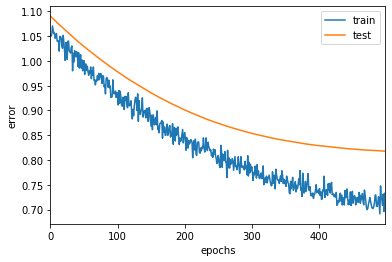

In [39]:
E.plot()
plt.xlabel('epochs')
plt.ylabel('error')
plt.savefig('result_latex/error1')

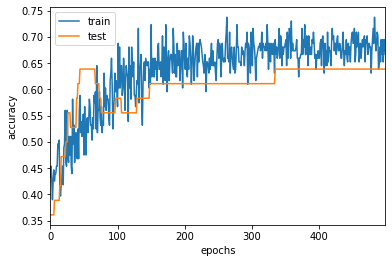

In [40]:
A.plot()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('result_latex/acc_1')

# Train on synthetic, test on real

### loading fake serie

In [90]:
ret_fake=pd.read_csv('fake.csv')
ret_fake_n=np.array(ret_fake)
ret_fake_n=ret_fake_n[:,1]

p_0=D_sp.iloc[0]
D_fake=p_0*cumreturn(ret_fake_n)
D_fake.shape

(5354,)

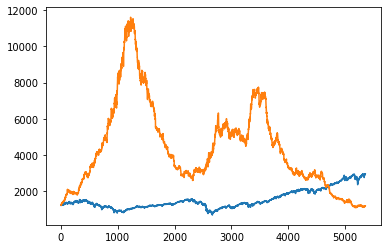

In [91]:
D_sp_t=np.array(D_sp[:len(D_sp)-1])
plt.plot(D_sp_t)
plt.plot(D_fake)

In [93]:
D_fake_df=pd.Series(D_fake)
D_fake_df.index=D_sp[:len(D_sp)-1].index
D_s,L_s=labelized_roll(D_fake_df)

D_fake_n=np.array(D_s)

x_train_s=D_fake_n

y_train_s=L_s
Y_train_s = keras.utils.to_categorical(y_train_s, nb_classes) 


## Train on synthetic

In [94]:
x_train_s=get_norm(x_train_s)
x_train_s=x_train_s.T


In [95]:
x_train_s.shape

(1061, 30)

In [96]:
hist_s = model.fit(x_train_s, Y_train_s, batch_size=batch_size, nb_epoch=nb_epochs, 
verbose=2, validation_data=(x_test, Y_test))

W0919 14:22:10.417629 11912 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1061 samples, validate on 213 samples
Epoch 1/500
1061/1061 - 0s - loss: 0.9634 - acc: 0.3798 - val_loss: 1.1398 - val_acc: 0.2770
Epoch 2/500
1061/1061 - 0s - loss: 0.9502 - acc: 0.4025 - val_loss: 1.1439 - val_acc: 0.2723
Epoch 3/500
1061/1061 - 0s - loss: 0.9427 - acc: 0.4100 - val_loss: 1.1480 - val_acc: 0.2770
Epoch 4/500
1061/1061 - 0s - loss: 0.9295 - acc: 0.4288 - val_loss: 1.1522 - val_acc: 0.2817
Epoch 5/500
1061/1061 - 0s - loss: 0.9263 - acc: 0.4279 - val_loss: 1.1564 - val_acc: 0.2770
Epoch 6/500
1061/1061 - 0s - loss: 0.9171 - acc: 0.4449 - val_loss: 1.1606 - val_acc: 0.2723
Epoch 7/500
1061/1061 - 0s - loss: 0.9090 - acc: 0.4656 - val_loss: 1.1648 - val_acc: 0.2770
Epoch 8/500
1061/1061 - 0s - loss: 0.8966 - acc: 0.4769 - val_loss: 1.1693 - val_acc: 0.3005
Epoch 9/500
1061/1061 - 0s - loss: 0.8940 - acc: 0.4618 - val_loss: 1.1736 - val_acc: 0.2958
Epoch 10/500
1061/1061 - 0s - loss: 0.8926 - acc: 0.4844 - val_loss: 1.1780 - val_acc: 0.2864
Epoch 11/500
1061/1061

Epoch 88/500
1061/1061 - 0s - loss: 0.6978 - acc: 0.6664 - val_loss: 1.5239 - val_acc: 0.3099
Epoch 89/500
1061/1061 - 0s - loss: 0.7001 - acc: 0.6607 - val_loss: 1.5277 - val_acc: 0.3099
Epoch 90/500
1061/1061 - 0s - loss: 0.7040 - acc: 0.6711 - val_loss: 1.5316 - val_acc: 0.3099
Epoch 91/500
1061/1061 - 0s - loss: 0.6980 - acc: 0.6748 - val_loss: 1.5355 - val_acc: 0.3099
Epoch 92/500
1061/1061 - 0s - loss: 0.7022 - acc: 0.6786 - val_loss: 1.5391 - val_acc: 0.3099
Epoch 93/500
1061/1061 - 0s - loss: 0.7022 - acc: 0.6720 - val_loss: 1.5424 - val_acc: 0.3099
Epoch 94/500
1061/1061 - 0s - loss: 0.7059 - acc: 0.6607 - val_loss: 1.5457 - val_acc: 0.3099
Epoch 95/500
1061/1061 - 0s - loss: 0.6983 - acc: 0.6814 - val_loss: 1.5492 - val_acc: 0.3099
Epoch 96/500
1061/1061 - 0s - loss: 0.6947 - acc: 0.6616 - val_loss: 1.5529 - val_acc: 0.3099
Epoch 97/500
1061/1061 - 0s - loss: 0.6941 - acc: 0.6805 - val_loss: 1.5565 - val_acc: 0.3099
Epoch 98/500
1061/1061 - 0s - loss: 0.6963 - acc: 0.6758 - v

Epoch 175/500
1061/1061 - 0s - loss: 0.6762 - acc: 0.6795 - val_loss: 1.7474 - val_acc: 0.2958
Epoch 176/500
1061/1061 - 0s - loss: 0.6746 - acc: 0.6711 - val_loss: 1.7495 - val_acc: 0.2958
Epoch 177/500
1061/1061 - 0s - loss: 0.6708 - acc: 0.6824 - val_loss: 1.7513 - val_acc: 0.2958
Epoch 178/500
1061/1061 - 0s - loss: 0.6696 - acc: 0.6861 - val_loss: 1.7534 - val_acc: 0.2958
Epoch 179/500
1061/1061 - 0s - loss: 0.6801 - acc: 0.6758 - val_loss: 1.7550 - val_acc: 0.2958
Epoch 180/500
1061/1061 - 0s - loss: 0.6699 - acc: 0.6805 - val_loss: 1.7567 - val_acc: 0.2958
Epoch 181/500
1061/1061 - 0s - loss: 0.6783 - acc: 0.6711 - val_loss: 1.7586 - val_acc: 0.2958
Epoch 182/500
1061/1061 - 0s - loss: 0.6753 - acc: 0.6909 - val_loss: 1.7604 - val_acc: 0.2958
Epoch 183/500
1061/1061 - 0s - loss: 0.6818 - acc: 0.6899 - val_loss: 1.7620 - val_acc: 0.2958
Epoch 184/500
1061/1061 - 0s - loss: 0.6802 - acc: 0.6852 - val_loss: 1.7636 - val_acc: 0.2958
Epoch 185/500
1061/1061 - 0s - loss: 0.6737 - acc:

Epoch 262/500
1061/1061 - 0s - loss: 0.6545 - acc: 0.6937 - val_loss: 1.8554 - val_acc: 0.3099
Epoch 263/500
1061/1061 - 0s - loss: 0.6627 - acc: 0.6871 - val_loss: 1.8560 - val_acc: 0.3099
Epoch 264/500
1061/1061 - 0s - loss: 0.6600 - acc: 0.6824 - val_loss: 1.8569 - val_acc: 0.3099
Epoch 265/500
1061/1061 - 0s - loss: 0.6682 - acc: 0.6880 - val_loss: 1.8577 - val_acc: 0.3099
Epoch 266/500
1061/1061 - 0s - loss: 0.6612 - acc: 0.6956 - val_loss: 1.8589 - val_acc: 0.3099
Epoch 267/500
1061/1061 - 0s - loss: 0.6730 - acc: 0.6795 - val_loss: 1.8597 - val_acc: 0.3099
Epoch 268/500
1061/1061 - 0s - loss: 0.6631 - acc: 0.6890 - val_loss: 1.8604 - val_acc: 0.3099
Epoch 269/500
1061/1061 - 0s - loss: 0.6728 - acc: 0.6777 - val_loss: 1.8613 - val_acc: 0.3052
Epoch 270/500
1061/1061 - 0s - loss: 0.6552 - acc: 0.6927 - val_loss: 1.8624 - val_acc: 0.3052
Epoch 271/500
1061/1061 - 0s - loss: 0.6645 - acc: 0.6861 - val_loss: 1.8631 - val_acc: 0.3052
Epoch 272/500
1061/1061 - 0s - loss: 0.6622 - acc:

Epoch 349/500
1061/1061 - 0s - loss: 0.6610 - acc: 0.6993 - val_loss: 1.9122 - val_acc: 0.3005
Epoch 350/500
1061/1061 - 0s - loss: 0.6634 - acc: 0.6918 - val_loss: 1.9129 - val_acc: 0.3005
Epoch 351/500
1061/1061 - 0s - loss: 0.6603 - acc: 0.6833 - val_loss: 1.9135 - val_acc: 0.3005
Epoch 352/500
1061/1061 - 0s - loss: 0.6670 - acc: 0.6880 - val_loss: 1.9139 - val_acc: 0.3005
Epoch 353/500
1061/1061 - 0s - loss: 0.6589 - acc: 0.7050 - val_loss: 1.9144 - val_acc: 0.3005
Epoch 354/500
1061/1061 - 0s - loss: 0.6585 - acc: 0.6890 - val_loss: 1.9149 - val_acc: 0.3005
Epoch 355/500
1061/1061 - 0s - loss: 0.6673 - acc: 0.6909 - val_loss: 1.9149 - val_acc: 0.3005
Epoch 356/500
1061/1061 - 0s - loss: 0.6575 - acc: 0.6880 - val_loss: 1.9157 - val_acc: 0.3005
Epoch 357/500
1061/1061 - 0s - loss: 0.6603 - acc: 0.6843 - val_loss: 1.9158 - val_acc: 0.3005
Epoch 358/500
1061/1061 - 0s - loss: 0.6643 - acc: 0.6880 - val_loss: 1.9159 - val_acc: 0.3005
Epoch 359/500
1061/1061 - 0s - loss: 0.6566 - acc:

Epoch 436/500
1061/1061 - 0s - loss: 0.6525 - acc: 0.6899 - val_loss: 1.9457 - val_acc: 0.3005
Epoch 437/500
1061/1061 - 0s - loss: 0.6565 - acc: 0.6946 - val_loss: 1.9459 - val_acc: 0.3005
Epoch 438/500
1061/1061 - 0s - loss: 0.6601 - acc: 0.6871 - val_loss: 1.9462 - val_acc: 0.3005
Epoch 439/500
1061/1061 - 0s - loss: 0.6517 - acc: 0.6975 - val_loss: 1.9466 - val_acc: 0.3005
Epoch 440/500
1061/1061 - 0s - loss: 0.6498 - acc: 0.7003 - val_loss: 1.9469 - val_acc: 0.3005
Epoch 441/500
1061/1061 - 0s - loss: 0.6539 - acc: 0.6909 - val_loss: 1.9472 - val_acc: 0.3005
Epoch 442/500
1061/1061 - 0s - loss: 0.6446 - acc: 0.6946 - val_loss: 1.9478 - val_acc: 0.3005
Epoch 443/500
1061/1061 - 0s - loss: 0.6599 - acc: 0.6833 - val_loss: 1.9481 - val_acc: 0.3005
Epoch 444/500
1061/1061 - 0s - loss: 0.6541 - acc: 0.6871 - val_loss: 1.9485 - val_acc: 0.3005
Epoch 445/500
1061/1061 - 0s - loss: 0.6559 - acc: 0.6956 - val_loss: 1.9488 - val_acc: 0.3005
Epoch 446/500
1061/1061 - 0s - loss: 0.6559 - acc:

## Results

In [104]:
log_s = pd.DataFrame(hist_s.history)

E=pd.concat([log_s['loss'],log_s['val_loss']],axis=1)
E.columns=['train','test']
A=pd.concat([log_s['acc'],log_s['val_acc']],axis=1)
A.columns=E.columns



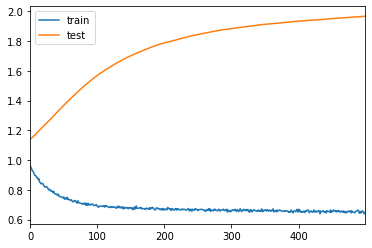

In [105]:
E.plot()

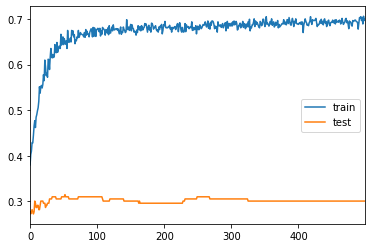

In [106]:
A.plot()

## using 30 fake series for the training

In [41]:
ret_fake=pd.read_csv('fake30_spx.csv')
ret_fake_n=np.array(ret_fake)
ret_fake_n=ret_fake_n[:,1:31]
ret_fake_n=pd.DataFrame(ret_fake_n)

p_0=D_sp.iloc[0]
#D_fake=p_0*cumreturn(ret_fake_n)
#D_fake=p_0*ret_fake_n
#D_fake.shape

In [42]:
D_fake=ret_fake_n
D_true=cumreturn(get_return(D_sp))

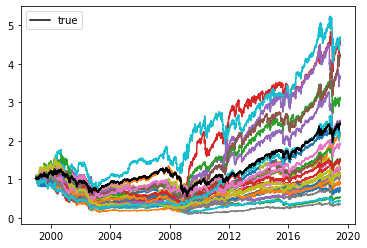

In [43]:
D_fake.index=D_true.index
plt.plot(D_fake)
plt.plot(D_true,color='black',label='true')
plt.legend()
plt.savefig('result_latex/30samples.pdf')


In [44]:
D_fake.columns=[str(k) for k in range(30)]
L_D_s=[]
L=[]
for k in range(30):
    serie=D_fake[str(k)]
    D_s,L_s=labelized_roll(serie)
    L_D_s.append(D_s)
    L.append(L_s)
    
    

In [45]:
front=848
for k in range(len(L_D_s)):
    D_n=L_D_s[k]
    D_n=np.array(D)
    x_train=D_n[:,0:front]
    L_D_s[k]=x_train

#1 version  among the 30: as in the first case
L_D_s[1].shape

(30, 177)

In [46]:
#flatten label vector
L_a=np.array(L)
L_a_n=L_a[:,0:front]
L_a_flatt=L_a_n.flatten()
L_a_flatt.shape

(5310,)

In [47]:
#flatten return vector
D_final=np.zeros((30,front*30))
D_final=pd.concat([pd.DataFrame(L_D_s[k]) for k in range(len(L_D_s))],axis=1)
D_final.shape

(30, 5310)

In [48]:
D_fake_n=np.array(D_final)

x_train_s=D_fake_n

y_train_s=L_a_flatt
Y_train_s = keras.utils.to_categorical(y_train_s, nb_classes) 
Y_train_s.shape

(5310, 3)

In [49]:
x_train_s=get_norm(x_train_s)
x_train_s=x_train_s.T
x_train_s.shape

(5310, 30)

In [50]:
hist_s = model.fit(x_train_s, Y_train_s, batch_size=batch_size, nb_epoch=nb_epochs, 
verbose=2, validation_data=(x_test, Y_test))

W0919 14:31:23.570114 13524 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 5310 samples, validate on 36 samples
Epoch 1/500
5310/5310 - 1s - loss: 0.7846 - acc: 0.6211 - val_loss: 0.8164 - val_acc: 0.6111
Epoch 2/500
5310/5310 - 0s - loss: 0.7820 - acc: 0.6245 - val_loss: 0.8150 - val_acc: 0.6111
Epoch 3/500
5310/5310 - 0s - loss: 0.7807 - acc: 0.6250 - val_loss: 0.8139 - val_acc: 0.6111
Epoch 4/500
5310/5310 - 0s - loss: 0.7710 - acc: 0.6335 - val_loss: 0.8128 - val_acc: 0.6111
Epoch 5/500
5310/5310 - 0s - loss: 0.7763 - acc: 0.6356 - val_loss: 0.8118 - val_acc: 0.6111
Epoch 6/500
5310/5310 - 0s - loss: 0.7700 - acc: 0.6324 - val_loss: 0.8109 - val_acc: 0.6111
Epoch 7/500
5310/5310 - 0s - loss: 0.7687 - acc: 0.6384 - val_loss: 0.8099 - val_acc: 0.6111
Epoch 8/500
5310/5310 - 0s - loss: 0.7730 - acc: 0.6320 - val_loss: 0.8090 - val_acc: 0.6111
Epoch 9/500
5310/5310 - 0s - loss: 0.7667 - acc: 0.6427 - val_loss: 0.8080 - val_acc: 0.5556
Epoch 10/500
5310/5310 - 1s - loss: 0.7651 - acc: 0.6420 - val_loss: 0.8072 - val_acc: 0.5556
Epoch 11/500
5310/5310 

Epoch 88/500
5310/5310 - 1s - loss: 0.7240 - acc: 0.6785 - val_loss: 0.7338 - val_acc: 0.6667
Epoch 89/500
5310/5310 - 0s - loss: 0.7234 - acc: 0.6802 - val_loss: 0.7329 - val_acc: 0.6667
Epoch 90/500
5310/5310 - 0s - loss: 0.7225 - acc: 0.6808 - val_loss: 0.7321 - val_acc: 0.6944
Epoch 91/500
5310/5310 - 0s - loss: 0.7194 - acc: 0.6812 - val_loss: 0.7312 - val_acc: 0.6944
Epoch 92/500
5310/5310 - 0s - loss: 0.7227 - acc: 0.6780 - val_loss: 0.7303 - val_acc: 0.6944
Epoch 93/500
5310/5310 - 0s - loss: 0.7199 - acc: 0.6770 - val_loss: 0.7293 - val_acc: 0.6944
Epoch 94/500
5310/5310 - 0s - loss: 0.7256 - acc: 0.6755 - val_loss: 0.7285 - val_acc: 0.6944
Epoch 95/500
5310/5310 - 0s - loss: 0.7203 - acc: 0.6814 - val_loss: 0.7277 - val_acc: 0.6944
Epoch 96/500
5310/5310 - 0s - loss: 0.7253 - acc: 0.6736 - val_loss: 0.7267 - val_acc: 0.6944
Epoch 97/500
5310/5310 - 0s - loss: 0.7192 - acc: 0.6876 - val_loss: 0.7258 - val_acc: 0.6944
Epoch 98/500
5310/5310 - 0s - loss: 0.7207 - acc: 0.6768 - v

Epoch 175/500
5310/5310 - 0s - loss: 0.6923 - acc: 0.6991 - val_loss: 0.6632 - val_acc: 0.7222
Epoch 176/500
5310/5310 - 0s - loss: 0.6971 - acc: 0.6977 - val_loss: 0.6625 - val_acc: 0.7222
Epoch 177/500
5310/5310 - 0s - loss: 0.6971 - acc: 0.6987 - val_loss: 0.6618 - val_acc: 0.7222
Epoch 178/500
5310/5310 - 0s - loss: 0.6964 - acc: 0.6985 - val_loss: 0.6611 - val_acc: 0.7222
Epoch 179/500
5310/5310 - 0s - loss: 0.6927 - acc: 0.7041 - val_loss: 0.6604 - val_acc: 0.7222
Epoch 180/500
5310/5310 - 0s - loss: 0.6973 - acc: 0.6977 - val_loss: 0.6597 - val_acc: 0.7222
Epoch 181/500
5310/5310 - 0s - loss: 0.6983 - acc: 0.6977 - val_loss: 0.6590 - val_acc: 0.7222
Epoch 182/500
5310/5310 - 0s - loss: 0.6940 - acc: 0.7024 - val_loss: 0.6585 - val_acc: 0.7222
Epoch 183/500
5310/5310 - 0s - loss: 0.6935 - acc: 0.7064 - val_loss: 0.6577 - val_acc: 0.7222
Epoch 184/500
5310/5310 - 0s - loss: 0.6881 - acc: 0.7030 - val_loss: 0.6569 - val_acc: 0.7222
Epoch 185/500
5310/5310 - 0s - loss: 0.6914 - acc:

Epoch 262/500
5310/5310 - 0s - loss: 0.6708 - acc: 0.7175 - val_loss: 0.6072 - val_acc: 0.7500
Epoch 263/500
5310/5310 - 0s - loss: 0.6697 - acc: 0.7139 - val_loss: 0.6066 - val_acc: 0.7500
Epoch 264/500
5310/5310 - 0s - loss: 0.6752 - acc: 0.7094 - val_loss: 0.6061 - val_acc: 0.7500
Epoch 265/500
5310/5310 - 0s - loss: 0.6692 - acc: 0.7115 - val_loss: 0.6055 - val_acc: 0.7500
Epoch 266/500
5310/5310 - 0s - loss: 0.6733 - acc: 0.7119 - val_loss: 0.6050 - val_acc: 0.7500
Epoch 267/500
5310/5310 - 1s - loss: 0.6709 - acc: 0.7092 - val_loss: 0.6045 - val_acc: 0.7500
Epoch 268/500
5310/5310 - 1s - loss: 0.6677 - acc: 0.7183 - val_loss: 0.6039 - val_acc: 0.7500
Epoch 269/500
5310/5310 - 0s - loss: 0.6714 - acc: 0.7132 - val_loss: 0.6034 - val_acc: 0.7500
Epoch 270/500
5310/5310 - 0s - loss: 0.6693 - acc: 0.7121 - val_loss: 0.6028 - val_acc: 0.7500
Epoch 271/500
5310/5310 - 0s - loss: 0.6692 - acc: 0.7145 - val_loss: 0.6022 - val_acc: 0.7500
Epoch 272/500
5310/5310 - 0s - loss: 0.6691 - acc:

Epoch 349/500
5310/5310 - 0s - loss: 0.6482 - acc: 0.7224 - val_loss: 0.5606 - val_acc: 0.7778
Epoch 350/500
5310/5310 - 0s - loss: 0.6559 - acc: 0.7247 - val_loss: 0.5602 - val_acc: 0.7778
Epoch 351/500
5310/5310 - 0s - loss: 0.6509 - acc: 0.7237 - val_loss: 0.5598 - val_acc: 0.7778
Epoch 352/500
5310/5310 - 0s - loss: 0.6506 - acc: 0.7190 - val_loss: 0.5594 - val_acc: 0.7778
Epoch 353/500
5310/5310 - 0s - loss: 0.6521 - acc: 0.7239 - val_loss: 0.5589 - val_acc: 0.7778
Epoch 354/500
5310/5310 - 1s - loss: 0.6533 - acc: 0.7183 - val_loss: 0.5583 - val_acc: 0.7778
Epoch 355/500
5310/5310 - 1s - loss: 0.6511 - acc: 0.7337 - val_loss: 0.5578 - val_acc: 0.7778
Epoch 356/500
5310/5310 - 0s - loss: 0.6464 - acc: 0.7215 - val_loss: 0.5574 - val_acc: 0.7778
Epoch 357/500
5310/5310 - 0s - loss: 0.6488 - acc: 0.7260 - val_loss: 0.5568 - val_acc: 0.7778
Epoch 358/500
5310/5310 - 0s - loss: 0.6473 - acc: 0.7247 - val_loss: 0.5563 - val_acc: 0.7778
Epoch 359/500
5310/5310 - 0s - loss: 0.6530 - acc:

Epoch 436/500
5310/5310 - 0s - loss: 0.6324 - acc: 0.7395 - val_loss: 0.5211 - val_acc: 0.7778
Epoch 437/500
5310/5310 - 0s - loss: 0.6322 - acc: 0.7375 - val_loss: 0.5207 - val_acc: 0.7778
Epoch 438/500
5310/5310 - 0s - loss: 0.6361 - acc: 0.7363 - val_loss: 0.5202 - val_acc: 0.7778
Epoch 439/500
5310/5310 - 0s - loss: 0.6315 - acc: 0.7292 - val_loss: 0.5198 - val_acc: 0.7778
Epoch 440/500
5310/5310 - 0s - loss: 0.6353 - acc: 0.7335 - val_loss: 0.5194 - val_acc: 0.7778
Epoch 441/500
5310/5310 - 0s - loss: 0.6305 - acc: 0.7395 - val_loss: 0.5188 - val_acc: 0.7778
Epoch 442/500
5310/5310 - 0s - loss: 0.6315 - acc: 0.7339 - val_loss: 0.5184 - val_acc: 0.7778
Epoch 443/500
5310/5310 - 0s - loss: 0.6273 - acc: 0.7399 - val_loss: 0.5178 - val_acc: 0.7778
Epoch 444/500
5310/5310 - 0s - loss: 0.6332 - acc: 0.7345 - val_loss: 0.5176 - val_acc: 0.7778
Epoch 445/500
5310/5310 - 1s - loss: 0.6277 - acc: 0.7365 - val_loss: 0.5171 - val_acc: 0.7778
Epoch 446/500
5310/5310 - 1s - loss: 0.6292 - acc:

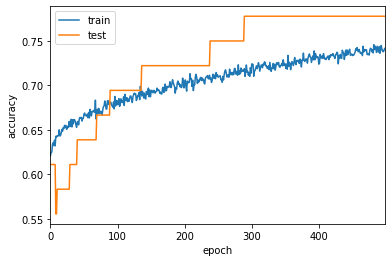

In [56]:
log = pd.DataFrame(hist_s.history)
E=pd.concat([log['loss'],log['val_loss']],axis=1)
E.columns=['train','test']
A=pd.concat([log['acc'],log['val_acc']],axis=1)
A.columns=E.columns
A.plot()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('result_latex/acc2')


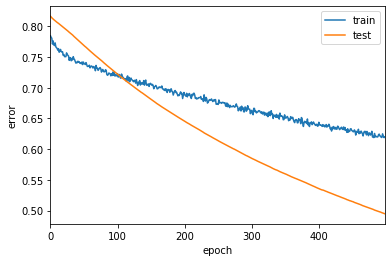

In [57]:
E.plot()
plt.xlabel('epoch')
plt.ylabel('error')
plt.savefig('result_latex/error2')